<a href="https://colab.research.google.com/github/GilgameshxZero/adversarial-ntks/blob/master/notebooks/kernel_svm_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mnist
!pip install jax jaxlib --upgrade
!pip install -q git+https://www.github.com/google/neural-tangents

     |████████████████████████████████| 491kB 12.7MB/s 
     |████████████████████████████████| 33.3MB 160kB/s 
  Created wheel for jax: filename=jax-0.2.5-cp36-none-any.whl size=576151 sha256=20568ca680165bdebe03884364a7ee921eb22fc5168c1c3768a197502b67f62d
  Stored in directory: /root/.cache/pip/wheels/d1/0d/3e/c44cadf26545452c29274cb512526d63f1840278edf59b80db
Successfully built jax
  Found existing installation: jax 0.2.4
    Uninstalling jax-0.2.4:
      Successfully uninstalled jax-0.2.4
  Found existing installation: jaxlib 0.1.56+cuda101
    Uninstalling jaxlib-0.1.56+cuda101:
      Successfully uninstalled jaxlib-0.1.56+cuda101


In [ ]:
import pathlib
import random
import pandas as pd
import matplotlib.pyplot as plt
import mnist
import sklearn
import jax.numpy as jnp
import functools
import copy
import numpy as np
import requests
import pickle
import tarfile
import tensorflow as tf

from sklearn import svm
from scipy.ndimage import interpolation

from jax import random
from jax.experimental import optimizers
from jax.api import jit, grad, vmap
from jax.config import config
config.update("jax_enable_x64", True)

import neural_tangents as nt
from neural_tangents import stax

In [ ]:
TMP_DIR = "./tmp/"
MN_TRAIN_SPLIT = 2000
MN_TEST_SPLIT = 10000
SAMPLE_IDX = 0
CF10_TRAIN_SPLIT = 2000
CF10_TEST_SPLIT = 2000

In [ ]:
pathlib.Path(TMP_DIR).mkdir(parents=True, exist_ok=True)
mnd = {}
mnd["train_x"] = mnist.download_and_parse_mnist_file(
  "train-images-idx3-ubyte.gz",
  target_dir=TMP_DIR
)
mnd["train_y"] = mnist.download_and_parse_mnist_file(
  "train-labels-idx1-ubyte.gz",
  target_dir=TMP_DIR
)
mnd["test_x"] = mnist.download_and_parse_mnist_file(
  "t10k-images-idx3-ubyte.gz",
  target_dir=TMP_DIR
)
mnd["test_y"] = mnist.download_and_parse_mnist_file(
  "t10k-labels-idx1-ubyte.gz",
  target_dir=TMP_DIR
)

cf10d = {}
(cf10d["train_x"], cf10d["train_y"]), (cf10d["test_x"], cf10d["test_y"]) = \
  tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


train_x.shape: (60000, 784)
train_y.shape: (60000,)
test_x.shape: (10000, 784)
test_y.shape: (10000,)
train_x[1] is False.


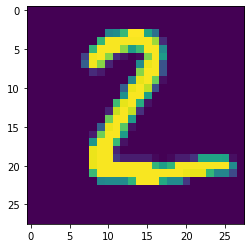

train_x.shape: (60000, 28, 28)
train_y.shape: (60000,)
test_x.shape: (10000, 28, 28)
test_y.shape: (10000,)
train_x[1] is False.


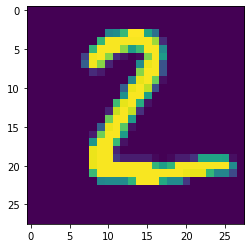

train_x.shape: (50000, 3072)
train_y.shape: (50000,)
test_x.shape: (10000, 3072)
test_y.shape: (10000,)
train_x[1] is True.


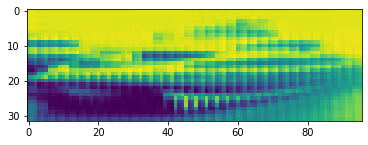

train_x.shape: (50000, 32, 32, 3)
train_y.shape: (50000,)
test_x.shape: (10000, 32, 32, 3)
test_y.shape: (10000,)
train_x[1] is True.


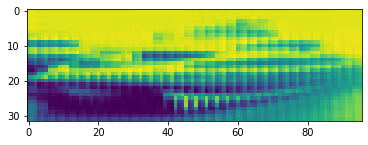

1.0 0.0
1.0 0.0


In [ ]:
def prep_data(data, flatten=False, binary=False):
  data["orig_dim"] = data["train_x"].shape[1]

  if flatten:
    data["train_x"] = data["train_x"].reshape((data["train_x"].shape[0], -1))
    data["test_x"] = data["test_x"].reshape((data["test_x"].shape[0], -1))

  if binary:
    n_classes = np.amax(data["train_y"]) + 1
    data["train_y"] = data["train_y"] >= (n_classes // 2)
    data["test_y"] = data["test_y"] >= (n_classes // 2)

  data["train_x"] = data["train_x"] / 255.0
  data["test_x"] = data["test_x"] / 255.0

  data["train_y"] = data["train_y"].reshape((data["train_y"].shape[0],))
  data["test_y"] = data["test_y"].reshape((data["test_y"].shape[0],))

  print("train_x.shape:", data["train_x"].shape)
  print("train_y.shape:", data["train_y"].shape)
  print("test_x.shape:", data["test_x"].shape)
  print("test_y.shape:", data["test_y"].shape)

  print("train_x[{}] is {}.".format(1, data["train_y"][1]))
  plt.imshow(data["test_x"][1].reshape((data["orig_dim"], -1)))
  plt.show()

mnds = copy.deepcopy(mnd)
cf10ds = copy.deepcopy(cf10d)
prep_data(mnd, flatten=True, binary=True)
prep_data(mnds, flatten=False, binary=True)
prep_data(cf10d, flatten=True, binary=True)
prep_data(cf10ds, flatten=False, binary=True)
print(np.amax(mnd["train_x"]), np.amin(mnd["train_x"]))
print(np.amax(cf10d["train_x"]), np.amin(cf10d["train_x"]))

In [ ]:
def clf_data_pred(clf, data, idx):
  return clf.predict([data["test_x"][idx]])[0]

def clf_data_pred_plot(clf, data, idx):
  pred = clf_data_pred(clf, data, idx)
  print("Truth//pred: {}//{}".format(data["test_y"][idx], pred))
  plt.imshow(data["test_x"][idx].reshape((28, -1)))
  plt.show()

def clf_data_acc(clf, data, test_split):
  return np.count_nonzero(
    data["test_y"][:test_split] == clf.predict(data["test_x"][:test_split])) / \
    test_split

In [ ]:
%%time
clf_rbf = svm.SVC(C=3, gamma="scale")
print(clf_rbf.fit(mnd["train_x"][:MN_TRAIN_SPLIT], mnd["train_y"][:MN_TRAIN_SPLIT]))
print("rbf test acc: {}".format(clf_data_acc(clf_rbf, mnd, MN_TEST_SPLIT)))

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
rbf test acc: 0.9165
CPU times: user 4.01 s, sys: 692 µs, total: 4.01 s
Wall time: 4.01 s


Truth//pred: True//True


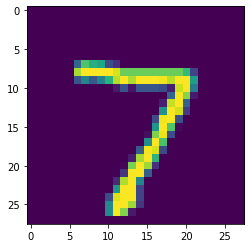

In [ ]:
clf_data_pred_plot(clf_rbf, mnd, 0)

In [ ]:
clf_poly_4 = svm.SVC(C=3, kernel="poly", degree=4)
print(clf_poly_4.fit(mnd["train_x"][:MN_TRAIN_SPLIT], mnd["train_y"][:MN_TRAIN_SPLIT]))
print("poly_4 test acc: {}".format(clf_data_acc(clf_poly_4, mnd, MN_TEST_SPLIT)))

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
poly_4 test acc: 0.916


In [ ]:
def kernel_dot(A, B):
  return np.dot(A, B.T)
clf_dot = svm.SVC(C=1, kernel=kernel_dot)
print(clf_dot.fit(mnd["train_x"][:MN_TRAIN_SPLIT], mnd["train_y"][:MN_TRAIN_SPLIT]))
print("dot test acc: {}".format(clf_data_acc(clf_dot, mnd, MN_TEST_SPLIT)))

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<function kernel_dot at 0x7f0bcbecad90>, max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
dot test acc: 0.799


In [ ]:
def kernel_laplacian(A, B):
  return sklearn.metrics.pairwise.laplacian_kernel(A, B, 0.01)
clf_laplacian = svm.SVC(C=3, kernel=kernel_laplacian)
print(clf_laplacian.fit(mnd["train_x"][:MN_TRAIN_SPLIT], mnd["train_y"][:MN_TRAIN_SPLIT]))
print("laplacian test acc: {}".format(clf_data_acc(clf_laplacian, mnd, MN_TEST_SPLIT)))

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<function kernel_laplacian at 0x7f0bcb9496a8>, max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
laplacian test acc: 0.9085


In [ ]:
%%time
clf_cf10_rbf = svm.SVC(C=3, gamma="scale")
print(clf_cf10_rbf.fit(cf10d["train_x"][:CF10_TRAIN_SPLIT], cf10d["train_y"][:CF10_TRAIN_SPLIT]))
print("cf10 rbf test acc: {}".format(clf_data_acc(clf_cf10_rbf, cf10d, CF10_TEST_SPLIT)))

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
cf10 rbf test acc: 0.615


In [ ]:
%%time
def kernel_cf10_laplacian(A, B):
  return sklearn.metrics.pairwise.laplacian_kernel(A, B, 0.01)
clf_cf10_laplacian = svm.SVC(C=3, kernel=kernel_cf10_laplacian)
print(clf_cf10_laplacian.fit(cf10d["train_x"][:CF10_TRAIN_SPLIT], cf10d["train_y"][:CF10_TRAIN_SPLIT]))
print("cf10 laplacian test acc: {}".format(clf_data_acc(clf_cf10_laplacian, cf10d, CF10_TRAIN_SPLIT)))

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<function kernel_cf10_laplacian at 0x7f0bc48cc598>, max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
cf10 laplacian test acc: 0.599
CPU times: user 22 s, sys: 3.51 ms, total: 22 s
Wall time: 22 s


In [ ]:
%%time
clf_poly_4 = svm.SVC(C=3, kernel="poly", degree=4)
print(clf_poly_4.fit(cf10d["train_x"][:CF10_TRAIN_SPLIT], cf10d["train_y"][:CF10_TRAIN_SPLIT]))
print("poly_4 test acc: {}".format(clf_data_acc(clf_poly_4, cf10d, CF10_TRAIN_SPLIT)))

SVC(C=3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=4, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
poly_4 test acc: 0.583
CPU times: user 27.3 s, sys: 0 ns, total: 27.3 s
Wall time: 27.3 s


In [ ]:
%%time
def kernel_dot(A, B):
  return np.dot(A, B.T)
clf_dot = svm.SVC(C=0.001, kernel=kernel_dot)
print(clf_dot.fit(cf10d["train_x"][:CF10_TRAIN_SPLIT], cf10d["train_y"][:CF10_TRAIN_SPLIT]))
print("dot test acc: {}".format(clf_data_acc(clf_dot, cf10d, CF10_TRAIN_SPLIT)))

SVC(C=0.001, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<function kernel_dot at 0x7f07ee897158>, max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)
dot test acc: 0.5925
CPU times: user 1.82 s, sys: 319 ms, total: 2.14 s
Wall time: 569 ms


In [ ]:
_, _, kernel_fn = stax.serial(
  stax.Dense(1, W_std=1, b_std=0), stax.Relu(),
  stax.Dense(1, W_std=1, b_std=0), stax.Relu(),
  stax.Dense(1, W_std=1, b_std=0), stax.Relu(),
  stax.Dense(1, W_std=1, b_std=0.1)
)

In [ ]:
def kfn(A, B):
  return kernel_fn(A, B, "ntk")
clf_ntk = svm.SVC(C=100, kernel=kfn)
print(clf_ntk.fit(mnd["train_x"][:MN_TRAIN_SPLIT], mnd["train_y"][:MN_TRAIN_SPLIT]))
print("ntk test acc: {}".format(clf_data_acc(clf_ntk, mnd, MN_TEST_SPLIT)))

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<function kfn at 0x7f07ee8ee950>, max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
ntk test acc: 0.9105


In [ ]:
#predict_fn = nt.predict.gradient_descent_mse_ensemble(kernel_fn, mnd["train_x"][:MN_TRAIN_SPLIT], 
  #mnd["train_y"][:MN_TRAIN_SPLIT].reshape((MN_TRAIN_SPLIT,1)))
#ntk_mean = predict_fn(x_test=mnd["test_x"][:MN_TEST_SPLIT], get="ntk").flatten()
#n_correct_ntk = np.count_nonzero((ntk_mean >= 0.5) == mnd["test_y"][:MN_TEST_SPLIT])
#print("ntk test error: {}".format(1 - n_correct_ntk / MN_TEST_SPLIT))

In [ ]:
def kfn(A, B):
  return kernel_fn(A, B, "ntk")
clf_ntk = svm.SVC(C=100, kernel=kfn)
print(clf_ntk.fit(cf10d["train_x"][:CF10_TEST_SPLIT], cf10d["train_y"][:CF10_TEST_SPLIT]))
print("ntk test acc: {}".format(clf_data_acc(clf_ntk, cf10d, CF10_TEST_SPLIT)))

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<function kfn at 0x7f0bcb8af378>, max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
ntk test acc: 0.6065


In [ ]:
_, _, kernel_fn = stax.serial(
  stax.Conv(1, (3, 3), W_std=1, b_std=0), stax.Relu(),
  stax.Conv(1, (3, 3), W_std=1, b_std=0), stax.Relu(),
  stax.Conv(1, (3, 3), W_std=1, b_std=0), stax.Relu(),
  stax.Conv(1, (3, 3), W_std=1, b_std=0), stax.Relu(),
  stax.Conv(1, (3, 3), W_std=1, b_std=0), stax.Relu(),
  # stax.GlobalAvgPool(),
  stax.Flatten(),
  stax.Dense(1, W_std=1, b_std=1)
)

In [ ]:
%%time
def kfn(A, B):
  return nt.batch(kernel_fn, batch_size=25)(A.reshape((-1,28,28,1)), B.reshape((-1,28,28,1)), "ntk")
clf_ntk = svm.SVC(C=1000, kernel=kfn)
print(clf_ntk.fit(mnd["train_x"][:MN_TRAIN_SPLIT], mnd["train_y"][:MN_TRAIN_SPLIT]))
print("ntk test acc: {}".format(clf_data_acc(clf_ntk, mnd, MN_TEST_SPLIT)))

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<function kfn at 0x7f07eea0c950>, max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
ntk test acc: 0.917
CPU times: user 10.9 s, sys: 2.22 s, total: 13.2 s
Wall time: 8.92 s


In [ ]:
%%time
def kfn(A, B):
  return nt.batch(kernel_fn, batch_size=100)(A.reshape((-1,32,32,3)), B.reshape((-1,32,32,3)), "ntk")
clf_ntk = svm.SVC(C=1000, kernel=kfn)
print(clf_ntk.fit(cf10d["train_x"][:MN_TRAIN_SPLIT], cf10d["train_y"][:MN_TRAIN_SPLIT]))
print("ntk test acc: {}".format(clf_data_acc(clf_ntk, cf10d, MN_TEST_SPLIT)))

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale',
    kernel=<function kfn at 0x7f07ee8e0c80>, max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)
ntk test acc: 0.63
CPU times: user 1.94 s, sys: 203 ms, total: 2.14 s
Wall time: 8.53 s
